In [55]:
from tensorflow.keras import Sequential, optimizers
from tensorflow.keras.layers import Dense, LSTM
import numpy as np
from matplotlib import pyplot

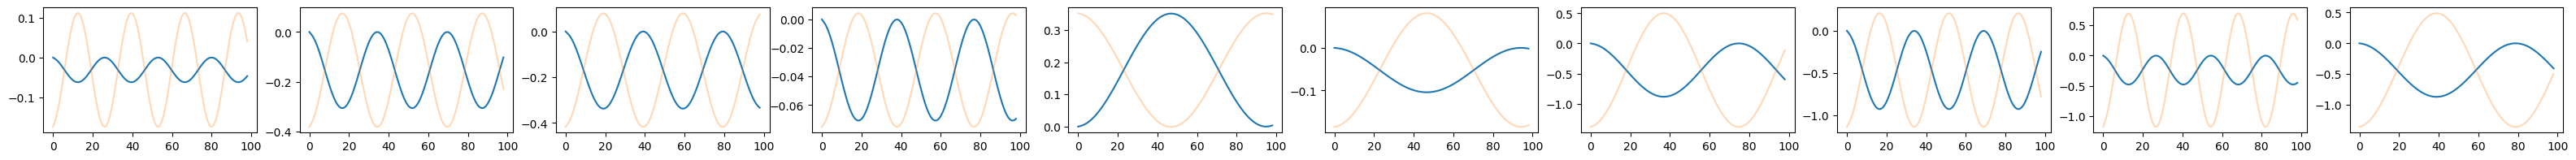

In [185]:
#simulation of coupled osscilators

def RK_solver(X0,T,system,epsilon):
    X=X0
    Nit=int(T/epsilon)
    t=0
    for it in range(Nit):
        k1=epsilon*system(X,t)
        #print("k1:",k1)
        k2=epsilon*system(X+k1/2.0,t+epsilon/2.0)
        #print("k2:",k2)
        k3=epsilon*system(X+k2/2.0,t+epsilon/2.0)
        #print("k3:",k3)
        k4=epsilon*system(X+k3,t+epsilon)
        #print("k4:",k4)
        X+=(k1+2.0*k2+2.0*k3+k4)/6.0
        t+=epsilon
    return X

class coupled_osscilators:
    def __init__(self,W,M,X0):
        #if not(len(M)==len(X0[0])/2 and len(W)==len(M)-1):
            #print(len(W),len(M),len(X0[0])/2)
            #print("input data lengths unequal!")
        self.w=W
        self.m=M
        self.X=X0
        self.N=len(M[0])

    def __call__(self,X,t):
        N=self.N
        F=np.zeros((len(X),2*N))
        F[:,N]=-(self.w.sum(1)*X[:,0]-((X[:,1:N])[:,:]*self.w).sum(1))/self.m[:,0]
        F[:,N+1:2*N]=((X[:,0,None]-X[:,1:N])*self.w)/self.m[:,1:N][:,:]
        F[:,0:N]=X[:,N:2*N]
        #print("X:",X)
        #print("F:",F)
        return F

def trajectory_batch(Nparticles,Nbatch,Nsteps,T,epsilon):
    N=Nparticles
    mass=np.array([[np.random.rand()/2.0+0.5 if i==0 else 0.1+np.random.rand()/2.0 for i in range(N)] for j in range(Nbatch)])
    weights=np.array([[np.random.rand()+0.1 for i in range(N-1)] for j in range(Nbatch)])
    #print("m:",mass)
    #print("w:",weights)
    X0=np.array([[0 if (i==0 or i>=N) else np.random.normal(0,1.0) for i in range(2*N)] for j in range(Nbatch)])
    system=coupled_osscilators(weights,mass,X0)
    sys_pos=np.zeros((Nsteps,Nbatch,2*N))
    sys_pos[0]=X0
    
    for it in range(1,Nsteps):
        sys_pos[it]=RK_solver(system.X,T/Nsteps,system,epsilon)
        system.X=sys_pos[it]
    return sys_pos

def print_trajectories(sys_pos,Nbatch):
    fig=pyplot.figure(figsize=(Nbatch*4,2))
    plt=fig.add_gridspec(1,Nbatch)
    plot=plt.subplots()
    for n in range(Nbatch):
        for i in range(int(len(sys_pos[0,0])/2)):
            data=np.transpose(sys_pos[0:-1,n,0:-1])
            plot[n].plot(data[i],label=i,alpha=(1.0 if i==0 else 0.3))
            #plot[n].legend()
    pyplot.show()

sys_pos=trajectory_batch(2,10,100,10.0,0.005)
print_trajectories(sys_pos,10)
    

In [190]:
#definig NN for simulation of coupled osscilators using LSTM
network=Sequential()
network.add(LSTM(20,input_shape=(None,1),return_sequences=True))
network.add(LSTM(20,return_sequences=True))
network.add(Dense(1,activation='linear'))
network.compile(loss='mean_squared_error',optimizer='adam')

In [196]:
#teaching funtion
def teach_network(Nit,Nbatch,Nparticles,Nsteps,T,epsilon):
    cost=[0]*Nit
    for it in range(Nit):
        batch=trajectory_batch(Nparticles,Nbatch,Nsteps,T,epsilon)
        batch_in=np.array([[[batch[j,i,0] if j<Nsteps/2 else 0] for j in range(Nsteps)] for i in range(Nbatch)])
        batch_out=np.array([[[batch[j,i,0]] for j in range(Nsteps)] for i in range(Nbatch)])
        #print(np.shape(batch),np.shape(batch_in),np.shape(batch_out))
        #print(batch_in,batch_out)
        cost[it]=network.train_on_batch(batch_in,batch_out)
        print(f"{it/Nit:1.0%} cost={cost[it]:0.5}",end="          \r")

teach_network(5000,50,5,100,10.0,0.01)


In [201]:
teach_network(5000,50,5,100,10.0,0.01)

(8, 100, 1)
(100,) (100,)
(100,) (100,)
(100,) (100,)
(100,) (100,)
(100,) (100,)
(100,) (100,)
(100,) (100,)
(100,) (100,)


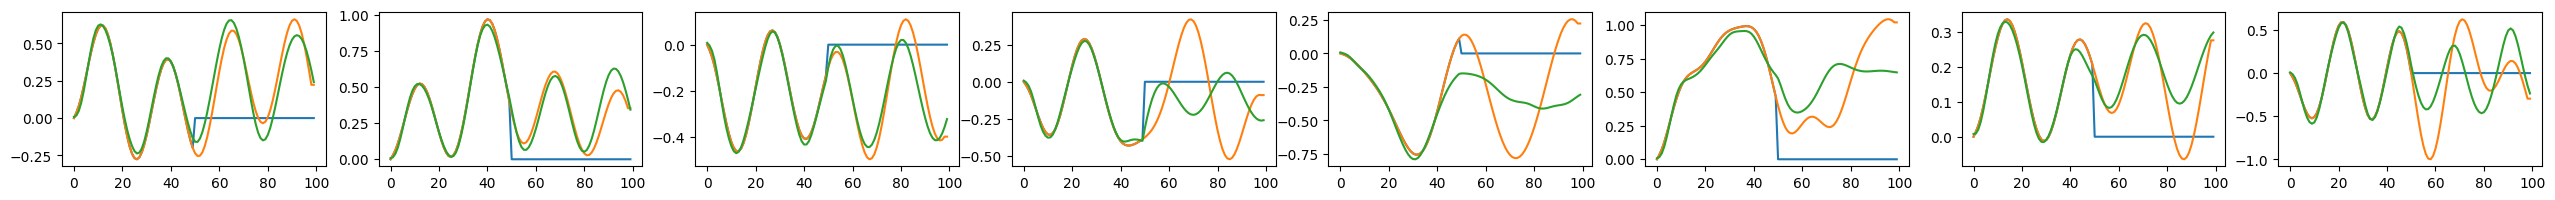

In [205]:
#comparison of actual trajectories (orange), LSTM prediction (green) and input data (blue)
def compare_results(network,Nparticles,Nbatch,Nsteps,T,epsilon):
    test_data=trajectory_batch(Nparticles,Nbatch,Nsteps,T,epsilon)
    test_true=np.array([[[test_data[j,i,0]] for j in range(Nsteps)] for i in range(Nbatch)])
    test_in=np.array([[[test_data[j,i,0] if j<Nsteps/2 else 0] for j in range(Nsteps)] for i in range(Nbatch)])
    test_out=network.predict_on_batch(test_in)
    print(np.shape(test_out))

    fig=pyplot.figure(figsize=(Nbatch*4,2))
    plot=fig.add_gridspec(1,Nbatch)
    plt=plot.subplots()
    for n in range(Nbatch):
        data1=test_in[n,:,0]
        data2=test_true[n,:,0]
        data3=test_out[n,:,0]
        print(np.shape(data1),np.shape(data2))
        plt[n].plot(data1)
        plt[n].plot(data2)
        plt[n].plot(data3)
        #plt[n].plot()
    pyplot.show()

compare_results(network,5,8,100,10,0.01)

In [255]:
#LSTM countdown: input is a sequence of 0 with number n (non-zero) at single postion, 
#as output NN generates a sequence with 1 exatly n steps away from non-zero signal

#batch x timesteps x vec_size
def countdown_batch(N,Nbatch):
    data=np.zeros((Nbatch,N,2))
    signal_pos=np.random.randint(0,N/2,size=Nbatch)
    period=np.random.randint(1,N/2-1,size=Nbatch)
    return_pos=signal_pos+period
    #print(signal_pos,period,return_pos)
    data[range(Nbatch),return_pos,1]=1  #this is really tricky with range(N) as index...
    data[range(Nbatch),signal_pos,0]=period
    return data

Ncountdown=20
countnet=Sequential()
countnet.add(LSTM(5,batch_input_shape=(None,Ncountdown,1),return_sequences=True))
countnet.add(LSTM(1,return_sequences=True))
countnet.compile(loss='mean_squared_error',optimizer='adam')

def teach_countdown(network,Nit,Nbatch,N):
    cost=np.zeros(Nit)
    for it in range(Nit):
        data=countdown_batch(N,Nbatch)
        data_in=data[0:Nbatch,0:N,0,None]
        data_out=data[0:Nbatch,0:N,1,None]
        cost[it]=network.train_on_batch(data_in,data_out)
        print(f"{it/Nit:1.0%} cost={cost[it]:0.5}",end="          \r")

teach_countdown(countnet,5000,50,Ncountdown)

In [258]:
def countdown_compare_results(network,Nbatch,N=Ncountdown):
    test_data=countdown_batch(N,Nbatch)
    test_in=test_data[0:Nbatch,0:N,0,None]
    test_out=test_data[0:Nbatch,0:N,1,None]
    test_res=network.predict_on_batch(test_in)
    success_rate=1.0-((test_out-test_res)**2).sum()/Nbatch/N
    print(f"success rate in countdown: {success_rate:.2%}")
    print("example:")
    n=np.random.randint(0,Nbatch)
    print("input:\n",test_in[n].flatten())
    print("ideal:\n",test_out[n].flatten())
    print("network output:\n",test_res[n].flatten())

countdown_compare_results(countnet,100)

success rate in countdown: 99.99%
example:
input:
 [0. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ideal:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
network output:
 [ 6.1422768e-03  5.6734560e-03  2.5937581e-03  1.2232253e-03
 -6.4942363e-04  2.1015510e-05  1.4540623e-04  7.5176795e-04
  1.0870451e-02  9.8517871e-01  5.0306018e-03 -6.6961828e-03
 -2.5989094e-03  5.6416629e-04 -2.3740688e-03 -3.8830615e-03
 -1.8010201e-03  8.4433408e-04  5.7166343e-04 -1.7069783e-03]
